In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import time

In [111]:
np.random.seed(60)
m = 1000
Data4d = np.random.randn(m, 4)
U, sigma, Vt = np.linalg.svd(Data4d)
pc1 = Vt[0]
pc2 = Vt[1]
pc3 = Vt[2]

In [112]:
proj_pc1 = Data4d @ pc1
proj_pc2 = Data4d @ pc2
proj_pc3 = Data4d @ pc3
proj_3d = Data4d @ Vt[:3].T

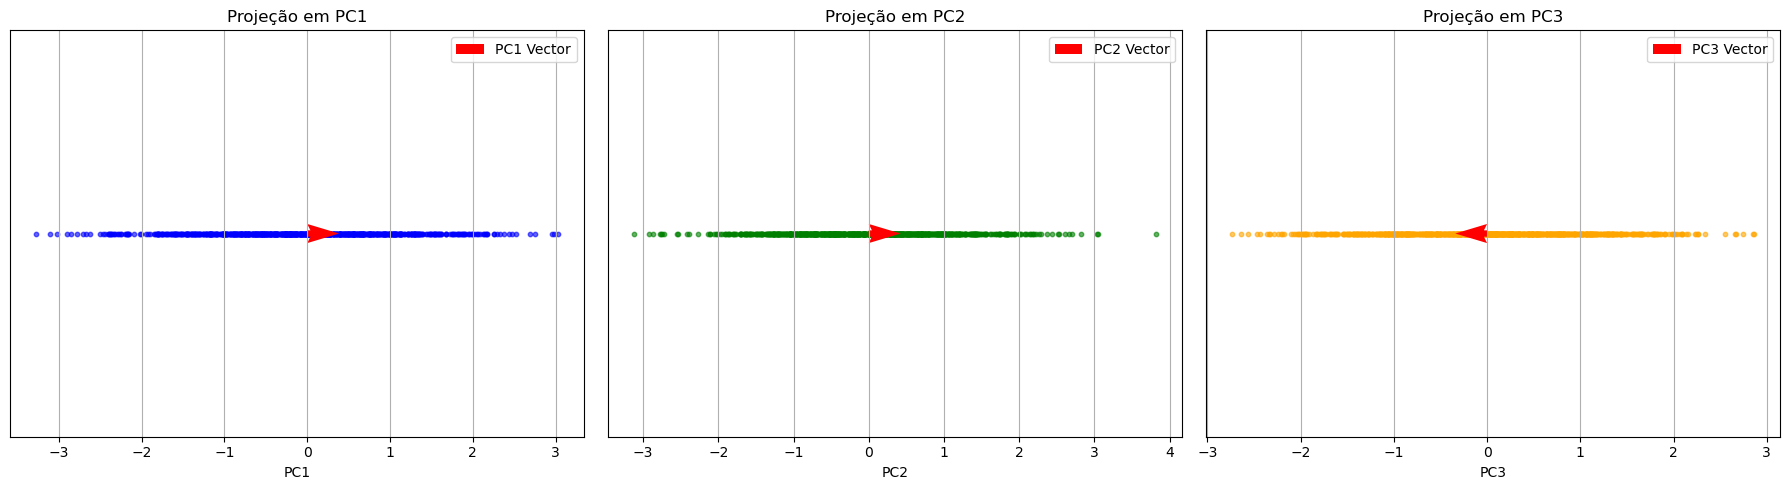

In [113]:
vector_scale = 0.2

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].scatter(proj_pc1, np.zeros_like(proj_pc1), alpha=0.6, color='blue', s=10)
axes[0].quiver(0, 0, vector_scale * pc1[0], 0, color='red', width=0.02, label="PC1 Vector")
axes[0].set_title("Projeção em PC1")
axes[0].set_xlabel("PC1")
axes[0].set_yticks([])
axes[0].grid()
axes[0].legend()


axes[1].scatter(proj_pc2, np.zeros_like(proj_pc2), alpha=0.6, color='green', s=10)
axes[1].quiver(0, 0, vector_scale * pc2[0], 0, color='red', width=0.02, label="PC2 Vector")
axes[1].set_title("Projeção em PC2")
axes[1].set_xlabel("PC2")
axes[1].set_yticks([])
axes[1].grid()
axes[1].legend()


axes[2].scatter(proj_pc3, np.zeros_like(proj_pc3), alpha=0.6, color='orange', s=10)
axes[2].quiver(0, 0, vector_scale * pc3[0], 0, color='red', width=0.02, label="PC3 Vector")
axes[2].set_title("Projeção em PC3")
axes[2].set_xlabel("PC3")
axes[2].set_yticks([])
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()

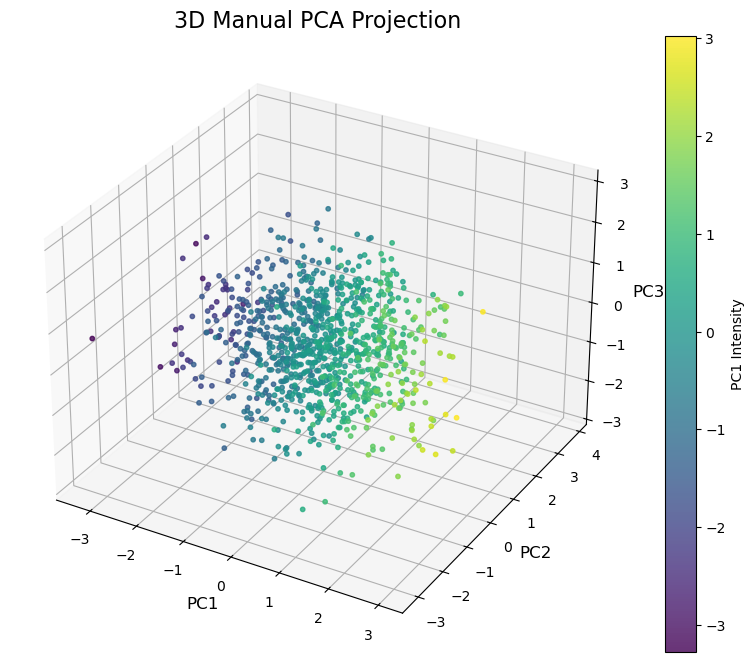

In [114]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=proj_3d[:, 0], cmap='viridis', s=10, alpha=0.8)

ax.set_title('3D Manual PCA Projection', fontsize=16)
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
fig.colorbar(sc, ax=ax, label='PC1 Intensity')

plt.show()

In [115]:
pca = PCA(3)
X3D = pca.fit_transform(Data4d)

In [116]:
print(pca.components_)

[[-0.41339037  0.63239034  0.63681681  0.15380247]
 [ 0.10106186 -0.68165101  0.68638996  0.23239453]
 [-0.861298   -0.36179835 -0.1185665  -0.33646649]]


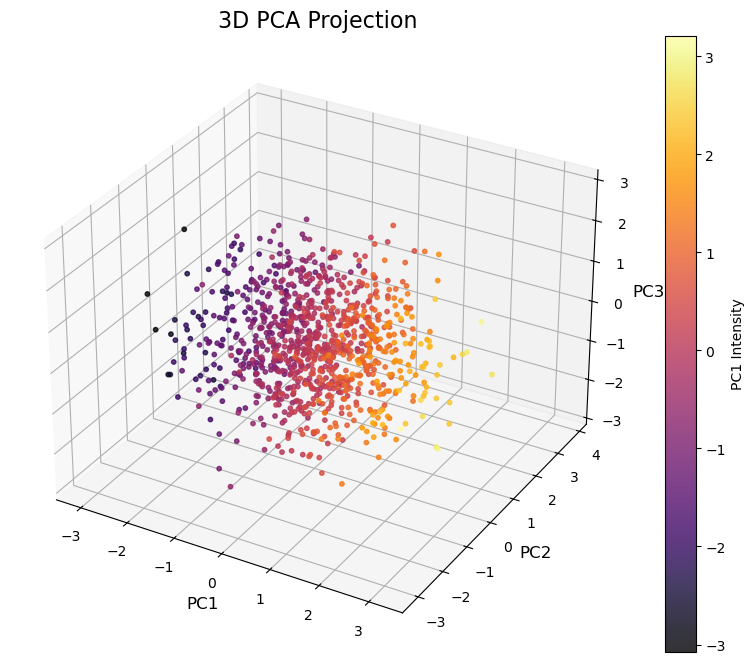

In [117]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X3D[:, 0], X3D[:, 1], X3D[:, 2], c=X3D[:, 0], cmap='inferno', s=10, alpha=0.8)

ax.set_title('3D PCA Projection', fontsize=16)
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_zlabel('PC3', fontsize=12)
fig.colorbar(sc, ax=ax, label='PC1 Intensity')

plt.show()

In [118]:
print(pca.explained_variance_ratio_)

[0.27470503 0.24923421 0.24302315]


In [140]:
mnist_images = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist_images.data[:60_000], mnist_images.target[:60_000]
X_test, y_test = mnist_images.data[60_000:], mnist_images.target[60_000:]

In [141]:
startpca = time.time()

pca_mnist = PCA()
pca_mnist.fit(X_train)
sum = np.cumsum(pca_mnist.explained_variance_ratio_)
d = np.argmax(sum >= 0.78) + 1
print(d)

39


In [142]:
#pca_mnist = PCA(n_components=0.78)
pca_mnist = PCA(d)
X = pca_mnist.fit_transform(X_train)
X_reconstructed = pca_mnist.inverse_transform(X)
print(pca_mnist.n_components_)
reconstruction_error = mean_squared_error(X_train, X_reconstructed)
print(f"Erro de reconstrução: {reconstruction_error:.4f}")
endpca = time.time()
timepca = endpca - startpca

39
Erro de reconstrução: 956.1963


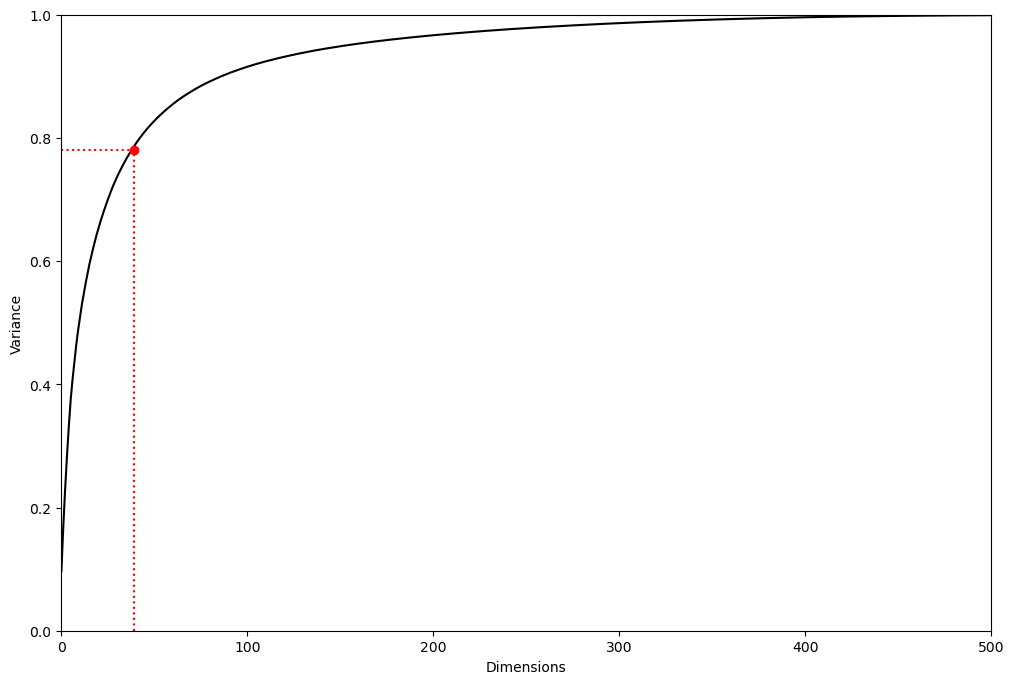

In [143]:
plt.figure(figsize = (12, 8))
plt.plot(sum, color='black')
plt.axis([0, 500, 0 , 1])
plt.xlabel("Dimensions")
plt.ylabel("Variance")
plt.plot([d, d], [0, 0.78], "r:")
plt.plot([0, d], [0.78, 0.78], "r:")
plt.plot(d, 0.78, "ro")
plt.show()

In [144]:
n_batches = 100

start_partial = time.time()

inc_pca = IncrementalPCA(n_components=39)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)
X_reconstructed = inc_pca.inverse_transform(X_reduced)
reconstruction_error = mean_squared_error(X_train, X_reconstructed)
print(f"Erro de reconstrução (IncrementalPCA): {reconstruction_error:.4f}")

end_partial = time.time()
time_partial = end_partial - start_partial
print(f"Tempo total de execução (IncrementalPCA): {time_partial:.4f} segundos")

Erro de reconstrução (IncrementalPCA): 958.3639
Tempo total de execução (IncrementalPCA): 24.4874 segundos


In [145]:

filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train
X_mmap.flush()

start_mmap = time.time()

X_mmap = np.memmap(filename, dtype='float32', mode='readonly').reshape(-1, 784)
pca_mnist = PCA(n_components=39)
pca_mnist.fit(X_mmap)

X_reduced = pca_mnist.transform(X_mmap)
X_reconstructed = pca_mnist.inverse_transform(X_reduced)
reconstruction_error = mean_squared_error(X_train, X_reconstructed)
print(f"Erro de reconstrução (memmap e fit): {reconstruction_error:.4f}")

end_mmap = time.time()
time_mmap = end_mmap - start_mmap
print(f"Tempo total de execução (memmap e fit): {time_mmap:.4f} segundos")

Erro de reconstrução (memmap e fit): 956.0255
Tempo total de execução (memmap e fit): 5.3564 segundos


In [146]:
print(f"\nComparação de tempos de execução:")
print(f"PCA: {timepca:.4f} segundos")
print(f"IncrementalPCA: {time_partial:.4f} segundos")
print(f"memmap e fit: {time_mmap:.4f} segundos")
print(f"Erro de reconstrução (PCA): {reconstruction_error:.4f}")
print(f"Erro de reconstrução (IncrementalPCA): {reconstruction_error:.4f}")
print(f"Erro de reconstrução (memmap e fit): {reconstruction_error:.4f}")


Comparação de tempos de execução:
PCA: 15.1072 segundos
IncrementalPCA: 24.4874 segundos
memmap e fit: 5.3564 segundos
Erro de reconstrução (PCA): 956.0255
Erro de reconstrução (IncrementalPCA): 956.0255
Erro de reconstrução (memmap e fit): 956.0255


In [123]:
Start1 = time.time()
preprocessing = make_pipeline(
    PCA(random_state = 60, svd_solver='full'),
    RandomForestClassifier(random_state = 60)
)

In [124]:
param_distrib = {
 "pca__n_components": np.arange(20, 120, 40),
 "randomforestclassifier__n_estimators": np.arange(50, 600)
}
rnd_search = RandomizedSearchCV(preprocessing, param_distrib, n_iter=10,
cv=3,
 random_state=60)
rnd_search.fit(X_train[:10000], y_train[:10000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca',
                                              PCA(random_state=60,
                                                  svd_solver='full')),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=60))]),
                   param_distributions={'pca__n_components': array([ 20,  60, 100]),
                                        'randomforestclassifier__n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,...
       505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517,
       518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530,
       531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543,
       544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556,
       557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569,
       570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
       583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595,
       596, 597, 598, 599])},
                   random_state=60)

In [125]:
print(rnd_search.best_params_)
End1 = time.time()
time_taken1 = End1 - Start1
print(time_taken1)

{'randomforestclassifier__n_estimators': 589, 'pca__n_components': 60}
690.214380979538


In [126]:
Start2 = time.time()
preprocessing = make_pipeline(
    PCA(random_state = 60, svd_solver='full'),
    SGDClassifier(random_state = 60)
)

In [127]:
param_distrib = {
 "pca__n_components": np.arange(20, 120, 40),
 "sgdclassifier__max_iter": np.linspace(100, 1000, 10, dtype=int), 
 "sgdclassifier__alpha": np.logspace(-5, 5, 10)
}
sdgc_search = RandomizedSearchCV(preprocessing, param_distrib, n_iter=10,
cv=3,
 random_state=60)
sdgc_search.fit(X_train[:10000], y_train[:10000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca',
                                              PCA(random_state=60,
                                                  svd_solver='full')),
                                             ('sgdclassifier',
                                              SGDClassifier(random_state=60))]),
                   param_distributions={'pca__n_components': array([ 20,  60, 100]),
                                        'sgdclassifier__alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                        'sgdclassifier__max_iter': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   random_state=60)

In [128]:
print(sdgc_search.best_params_)
End2 = time.time()
time_taken2 = End2 - Start2
print(time_taken2)

{'sgdclassifier__max_iter': 100, 'sgdclassifier__alpha': 100000.0, 'pca__n_components': 100}
57.558424949645996


In [129]:
y_pred_rnd = rnd_search.predict(X_test[:2000])
y_pred_sdgc = sdgc_search.predict(X_test[:2000])

print(f"Time (randomforestclassifier search): {time_taken1:.4f}")
print(f"Time (SGDClassifier Search): {time_taken2:.4f}")
accuracy_rnd = accuracy_score(y_test[:2000], y_pred_rnd)
print(f"Acurácia (randomforestclassifier search): {accuracy_rnd:.4f}")


accuracy_sdgc = accuracy_score(y_test[:2000], y_pred_sdgc)
print(f"Acurácia (SGDClassifier Search): {accuracy_sdgc:.4f}")


report_rnd = classification_report(y_test[:2000], y_pred_rnd)
print("Relatório de Classificação (randomforestclassifier search):")
print(report_rnd)


report_sdgc = classification_report(y_test[:2000], y_pred_sdgc)
print("Relatório de Classificação (SGDClassifier Search):")
print(report_sdgc)


Time (randomforestclassifier search): 690.2144
Time (SGDClassifier Search): 57.5584
Acurácia (randomforestclassifier search): 0.9085
Acurácia (SGDClassifier Search): 0.7285
Relatório de Classificação (randomforestclassifier search):
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       175
           1       0.96      0.98      0.97       234
           2       0.91      0.88      0.89       219
           3       0.87      0.91      0.89       207
           4       0.89      0.90      0.89       217
           5       0.92      0.87      0.89       179
           6       0.91      0.94      0.93       178
           7       0.92      0.90      0.91       205
           8       0.88      0.84      0.86       192
           9       0.88      0.87      0.88       194

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

Relatóri

In [130]:
Start3 = time.time()
preprocessing = make_pipeline(
    PCA(random_state = 60, svd_solver="randomized"),
    RandomForestClassifier(random_state = 60)
)

In [131]:
param_distrib = {
 "pca__n_components": np.arange(20, 120, 40),
 "randomforestclassifier__n_estimators": np.arange(50, 600)
}
rnd_search = RandomizedSearchCV(preprocessing, param_distrib, n_iter=10,
cv=3,
 random_state=60)
rnd_search.fit(X_train[:10000], y_train[:10000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca',
                                              PCA(random_state=60,
                                                  svd_solver='randomized')),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=60))]),
                   param_distributions={'pca__n_components': array([ 20,  60, 100]),
                                        'randomforestclassifier__n_estimators': array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,...
       505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517,
       518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530,
       531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543,
       544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556,
       557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569,
       570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
       583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595,
       596, 597, 598, 599])},
                   random_state=60)

In [132]:
print(rnd_search.best_params_)
End3 = time.time()
time_taken3 = End3 - Start3
print(time_taken3)

{'randomforestclassifier__n_estimators': 589, 'pca__n_components': 60}
778.203439950943


In [133]:
Start4 = time.time()
preprocessing = make_pipeline(
    PCA(random_state = 60, svd_solver="randomized"),
    SGDClassifier(random_state = 60)
)

In [134]:
param_distrib = {
 "pca__n_components": np.arange(20, 120, 40),
 "sgdclassifier__max_iter": np.linspace(100, 1000, 10, dtype=int), 
 "sgdclassifier__alpha": np.logspace(-5, 5, 10)
}
sdgc_search = RandomizedSearchCV(preprocessing, param_distrib, n_iter=10,
cv=3,
 random_state=60)
sdgc_search.fit(X_train[:10000], y_train[:10000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca',
                                              PCA(random_state=60,
                                                  svd_solver='randomized')),
                                             ('sgdclassifier',
                                              SGDClassifier(random_state=60))]),
                   param_distributions={'pca__n_components': array([ 20,  60, 100]),
                                        'sgdclassifier__alpha': array([1.00000000e-05, 1.29154967e-04, 1.66810054e-03, 2.15443469e-02,
       2.78255940e-01, 3.59381366e+00, 4.64158883e+01, 5.99484250e+02,
       7.74263683e+03, 1.00000000e+05]),
                                        'sgdclassifier__max_iter': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   random_state=60)

In [135]:
print(sdgc_search.best_params_)
End4 = time.time()
time_taken4 = End4 - Start4
print(time_taken4)

{'sgdclassifier__max_iter': 400, 'sgdclassifier__alpha': 0.0016681005372000592, 'pca__n_components': 100}
70.82595920562744


In [136]:
y_pred_rnd = rnd_search.predict(X_test[:2000])
y_pred_sdgc = sdgc_search.predict(X_test[:2000])

print(f"Time (randomforestclassifier search): {time_taken3:.4f}")
print(f"Time (SGDClassifier Search): {time_taken4:.4f}")
accuracy_rnd = accuracy_score(y_test[:2000], y_pred_rnd)
print(f"Acurácia (randomforestclassifier search): {accuracy_rnd:.4f}")


accuracy_sdgc = accuracy_score(y_test[:2000], y_pred_sdgc)
print(f"Acurácia (SGDClassifier Search): {accuracy_sdgc:.4f}")


report_rnd = classification_report(y_test[:2000], y_pred_rnd)
print("Relatório de Classificação (randomforestclassifier search):")
print(report_rnd)


report_sdgc = classification_report(y_test[:2000], y_pred_sdgc)
print("Relatório de Classificação (SGDClassifier Search):")
print(report_sdgc)


Time (randomforestclassifier search): 778.2034
Time (SGDClassifier Search): 70.8260
Acurácia (randomforestclassifier search): 0.9030
Acurácia (SGDClassifier Search): 0.7640
Relatório de Classificação (randomforestclassifier search):
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       175
           1       0.96      0.98      0.97       234
           2       0.90      0.87      0.89       219
           3       0.88      0.90      0.89       207
           4       0.91      0.88      0.89       217
           5       0.92      0.88      0.90       179
           6       0.90      0.94      0.92       178
           7       0.90      0.90      0.90       205
           8       0.85      0.83      0.84       192
           9       0.86      0.88      0.87       194

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Relatóri

In [137]:
print(f"(randomforestclassifier search full) {time_taken1}")
print(f"(SGDClassifier Search full) {time_taken2}")
print(f"(randomforestclassifier search randomized) {time_taken3}")
print(f"(SGDClassifier Search randomized) {time_taken4}")

randomforestclassifier search full) 690.214380979538
(SGDClassifier Search full) 57.558424949645996
(randomforestclassifier search randomized) 778.203439950943
(SGDClassifier Search randomized) 70.82595920562744
